## Anomaly detection

CPC and CPM Data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

% matplotlib inline
sns.set(font_scale=1)

In [5]:
def load_file(number=3):
    '''
    Loads the files for CPC and CPM and returns them in a dataframe
    '''
    file_name_cpc = 'exchange-' + str(number) + '_cpc_results.csv'
    file_name_cpm = 'exchange-' + str(number) + '_cpm_results.csv'
    
    cpc = pd.read_csv(file_name_cpc)
    cpc.columns = ['timestamp', 'cpc']
    
    cpm = pd.read_csv(file_name_cpm)
    cpm.columns = ['timestamp', 'cpm']
    
    assert(len(cpc) == (cpc['timestamp'] == cpm['timestamp']).sum())
    df = pd.concat([cpc, cpm['cpm']], axis=1)
    return df    

In [6]:
df = load_file()
df.head()

,timestamp,cpc,cpm
0,2011-07-01 00:15:01,0.102709,0.405423
1,2011-07-01 01:15:01,0.068039,0.433961
2,2011-07-01 02:15:01,0.077994,0.389268
3,2011-07-01 03:15:01,0.077682,0.368099
4,2011-07-01 04:15:01,0.077966,0.365234


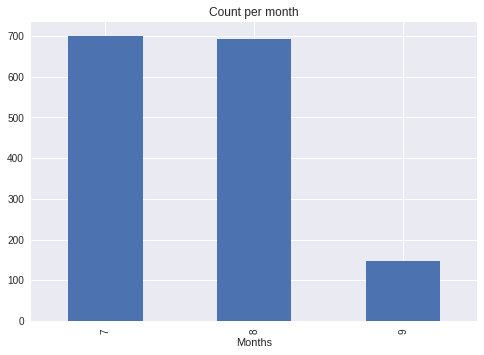

In [7]:
# When was this data taken?
pd.to_datetime(df['timestamp']).map(lambda x: x.date().month).value_counts().plot(kind='bar')
plt.title("Count per month")
plt.xlabel("Months")

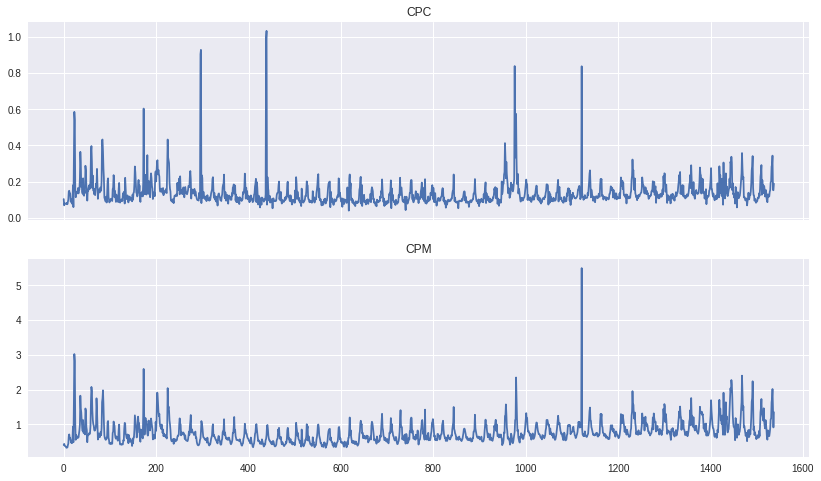

In [8]:
# First look at it
f,ax= plt.subplots(2, sharex=True, figsize=(14,8))
ax[0].plot(df['cpc'])
ax[1].plot(df['cpm'])

ax[0].title.set_text('CPC')
ax[1].title.set_text('CPM')


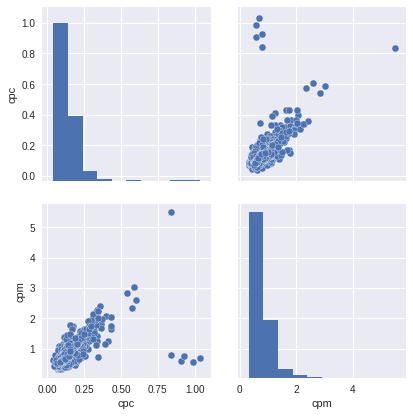

In [9]:
ax = sns.pairplot(df[['cpc','cpm']],size=3)

In [10]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Xs = ss.fit_transform(df[['cpc','cpm']].values)

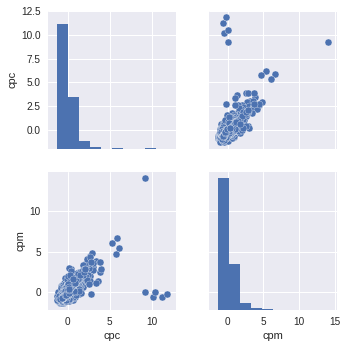

In [8]:
sns.pairplot(pd.DataFrame(Xs, columns = ['cpc', 'cpm']))

# Supervized Learning
For this we need labeled data. Let's create them!

In [13]:
from sklearn.cluster import DBSCAN    
from sklearn.metrics import silhouette_score

In [11]:
def plot_scatter_and_timeseries(X, labels):
    '''
    Custom plot of scatter plot between CPC and CPM + Timeseries
    '''
    cmap = plt.get_cmap('jet')
    plt.figure(figsize=(7,4))
    plt.scatter(X[:,0],X[:,1], c=labels, cmap=cmap)
    plt.colorbar()
    f, ax = plt.subplots(2,1, figsize=(14,8)) 
    ax[0].plot(range(len(X)), X[:,0], alpha=0.5)
    ax[0].scatter(range(len(X)), X[:,0], c=labels, cmap=cmap)
    ax[1].plot(range(len(X)), X[:,1], alpha=0.5)
    ax[1].scatter(range(len(X)), X[:,1], c=labels, cmap=cmap)
    

## DBSCAN

0.835477058503


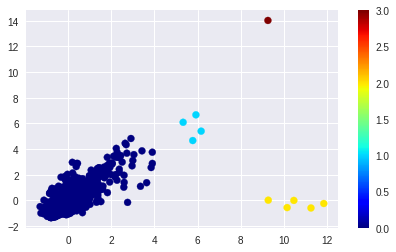

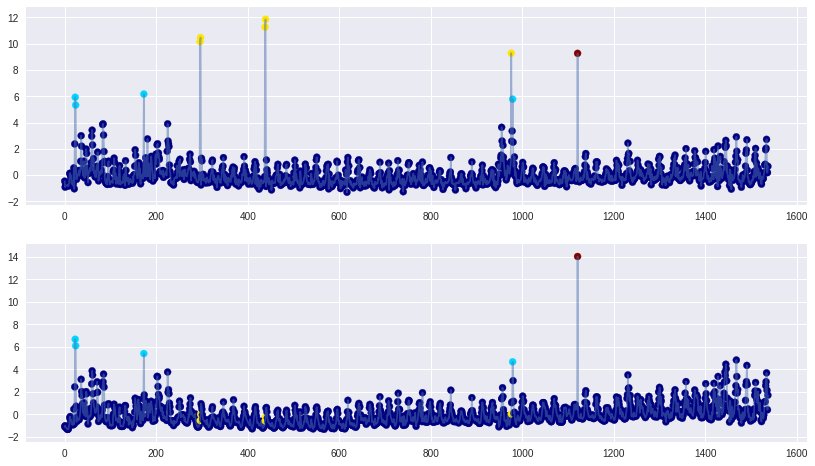

In [14]:
dbs = DBSCAN(eps=2, min_samples=1)
dbs.fit(Xs)
plot_scatter_and_timeseries(Xs, dbs.labels_)
print silhouette_score(Xs, dbs.labels_)

In [17]:
def DBSCAN_process(file_n=4):
    '''
    Loads a file and fits a DBSCAN class
    '''
    df = load_file(file_n)
    ss = StandardScaler()
    Xs = ss.fit_transform(df[['cpc','cpm']])
    dbs = DBSCAN(eps=2, min_samples=1)
    dbs.fit(Xs)
    plot_scatter_and_timeseries(Xs, dbs.labels_)
    if len(set(dbs.labels_)) > 1:
        print silhouette_score(Xs, dbs.labels_)
        
def w_DBSCAN(file_n=4):
    DBSCAN_process(file_n)

In [15]:
from ipywidgets import *
from IPython.display import display

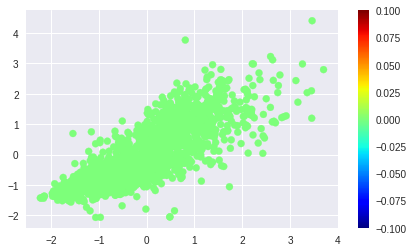

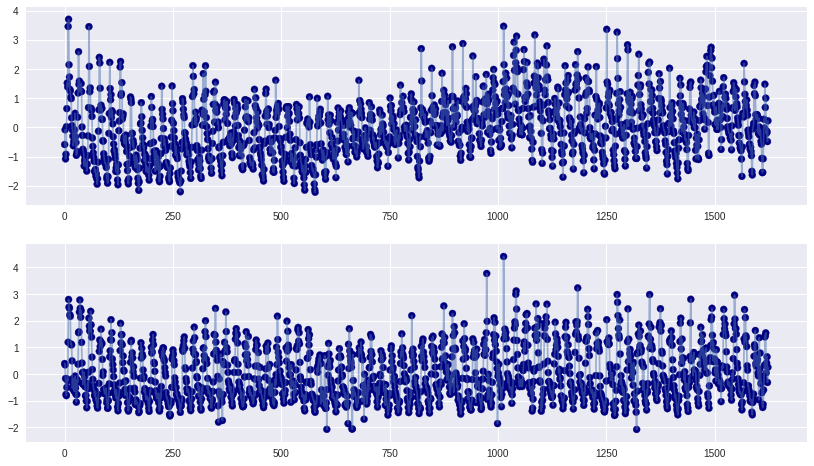

In [18]:
widgets.interact(w_DBSCAN, file_n=widgets.IntSlider(
    value=4,
    min=2,
    max=4,
    step=1,
    description='File Number:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
))


In [285]:
from sklearn.ensemble import RandomForestClassifier
y = [0 if x==0 else 1 for x in dbs.labels_]

rf = RandomForestClassifier(class_weight='balanced')
rf.fit(Xs,y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [307]:
def any_process(file_n, ss, classifier, invert=1):
    print type(classifier)
    df = load_file(file_n)
    Xs = ss.transform(df[['cpc','cpm']])
    plot_scatter_and_timeseries(Xs, invert*classifier.predict(Xs))
    
def w_any_process(file_n=4):
    any_process(file_n, ss=ss, classifier=rf)

<class 'sklearn.ensemble.forest.RandomForestClassifier'>


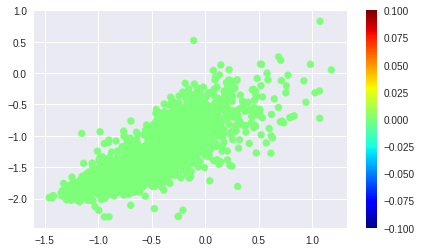

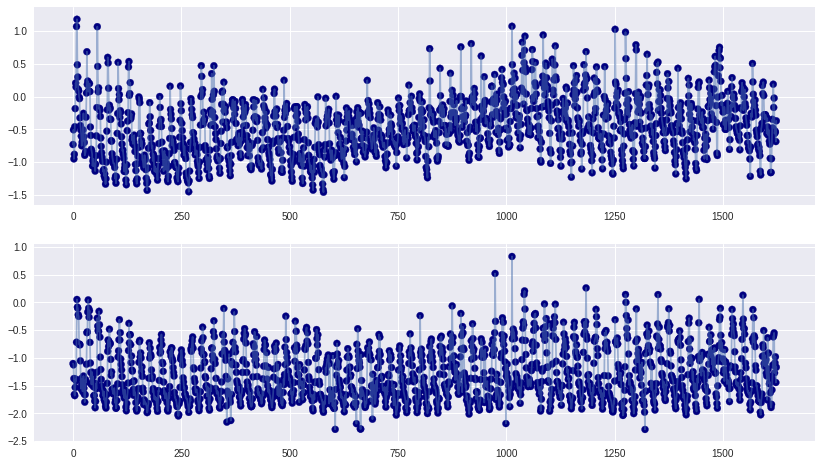

In [308]:
widgets.interact(w_any_process, file_n=widgets.IntSlider(
    value=4,
    min=2,
    max=4,
    step=1,
    description='File Number:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
))

## Unsupervized Learning

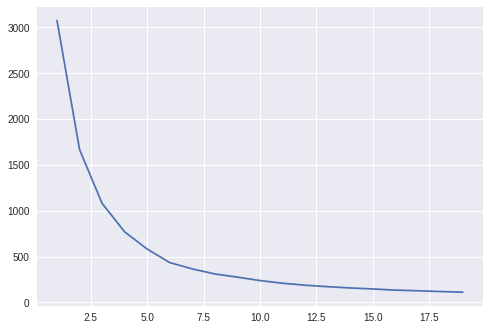

In [16]:
# KMeans
from sklearn.cluster import KMeans

n_clusters = 20
km = [KMeans(n_clusters=i) for i in range(1,n_clusters)]

inertia = []
for kmi in km:
    kmi.fit(Xs)
    inertia.append(kmi.inertia_)
    
plt.plot(range(1,n_clusters), inertia)

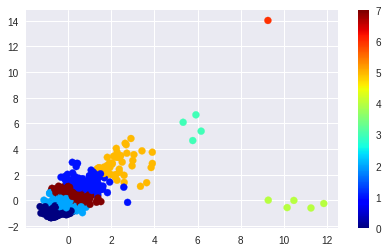

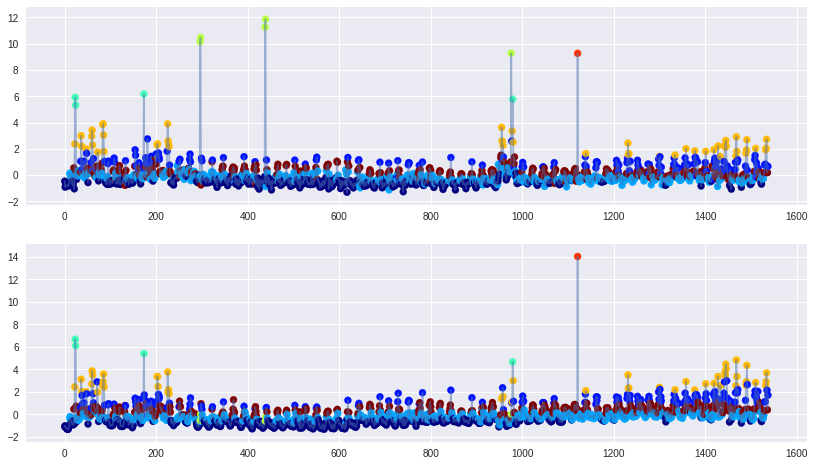

In [273]:
# Not exactly clear where to use the elbow criteria... 
# I'm choosing 8 clusters to show how KMeans is not the best for this
km = KMeans(n_clusters=8).fit(Xs)
plot_scatter_and_timeseries(Xs, km.labels_)

In [353]:
# SVM - OneClassSVM
from sklearn.svm import OneClassSVM 

def OneClassSVM_process(file_n):
    '''
    Loads a file and fits a OneClassSVM class. Returns the fitted and standarized classes
    '''
    df = load_file(file_n)
    ss = StandardScaler()
    Xs = ss.fit_transform(df[['cpc','cpm']])
    oc_svm = OneClassSVM(kernel='rbf', nu=0.001, gamma=0.1)
    oc_svm.fit(Xs)
    
    # This creates the countour plot
    xx, yy = np.meshgrid(np.linspace(min(Xs[:,0]), max(Xs[:,0])+1, 500), \
                     np.linspace(min(Xs[:,1]), max(Xs[:,1])+1, 500))
    z = oc_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = z.reshape(xx.shape)
    plt.figure(figsize=(7,4))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 8), cmap='PuBu')
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
    plt.scatter(Xs[:,0],Xs[:,1], alpha=0.8, c=oc_svm.predict(Xs), cmap='Dark2')
    ax = plt.gca()
    ax.set_xlim([Xs[:,0].min(),Xs[:,0].max()+1])
    ax.set_ylim([Xs[:,1].min(),Xs[:,1].max()+1])
    plt.title('Countour area')
    plt.xlabel('CPC')
    plt.ylabel('CPM')
    # Last plot
    #plot_scatter_and_timeseries(Xs, -oc_svm.predict(Xs))
    return oc_svm, ss

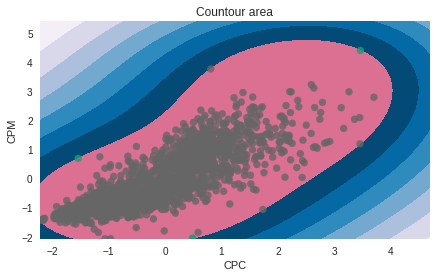

In [354]:
oc_svm, ss2 = OneClassSVM_process(2)

<class 'sklearn.svm.classes.OneClassSVM'>


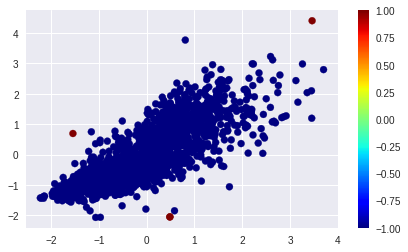

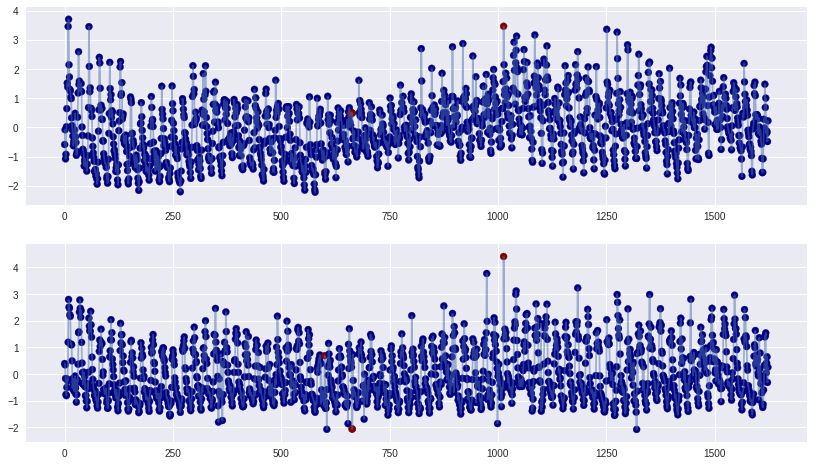

In [309]:
def w_any_process(file_n=4):
    any_process(file_n, ss=ss2, classifier=oc_svm, invert=-1)
    
widgets.interact(w_any_process, file_n=widgets.IntSlider(
    value=4,
    min=2,
    max=4,
    step=1,
    description='File Number:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
))

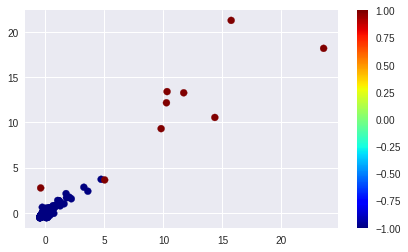

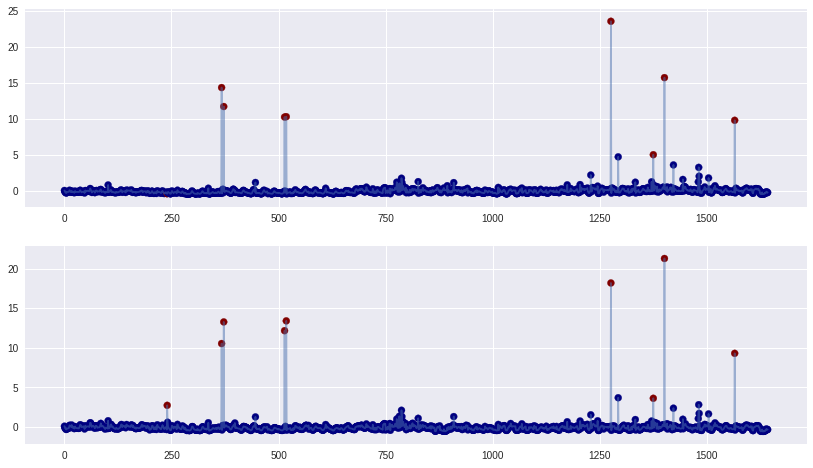

In [355]:
# EllipticEnvelope
from sklearn.covariance import EllipticEnvelope

def EllipticEnvelope_process(file_n):
    '''
    Loads a file and fits a EllipticEnvelope class. Returns the fitted and standarized classes
    '''
    df = load_file(file_n)
    ss = StandardScaler()
    Xs = ss.fit_transform(df[['cpc','cpm']])
    ee = EllipticEnvelope(contamination=0.005)
    ee.fit(Xs)
    
    plot_scatter_and_timeseries(Xs, -ee.predict(Xs))
    return ee, ss

ee, ss3 = EllipticEnvelope_process(4)

<class 'sklearn.covariance.outlier_detection.EllipticEnvelope'>


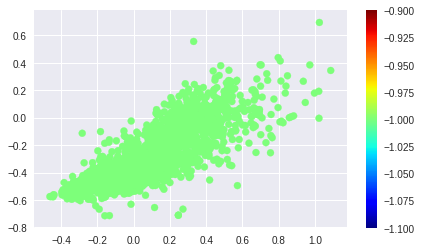

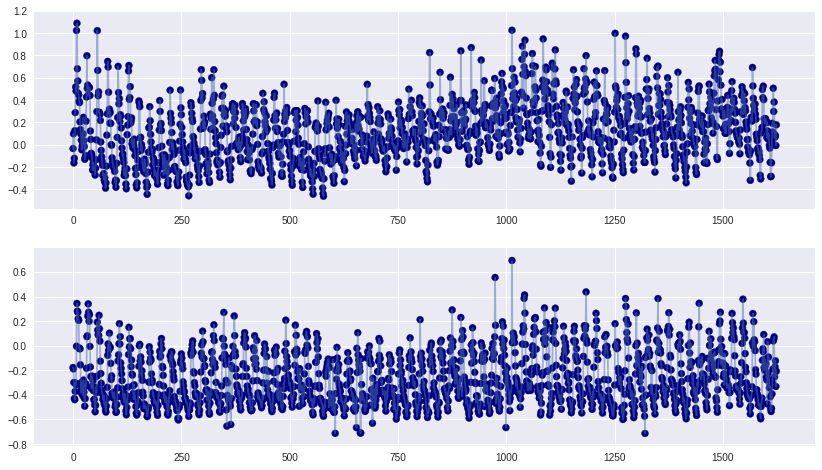

In [312]:
def w_any_process(file_n=4):
    any_process(file_n, ss=ss3, classifier=ee, invert=-1)
    
widgets.interact(w_any_process, file_n=widgets.IntSlider(
    value=4,
    min=2,
    max=4,
    step=1,
    description='File Number:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
))

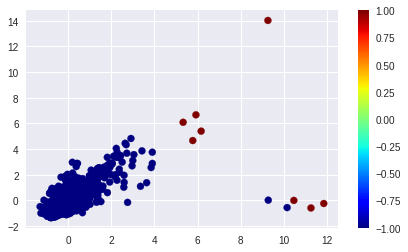

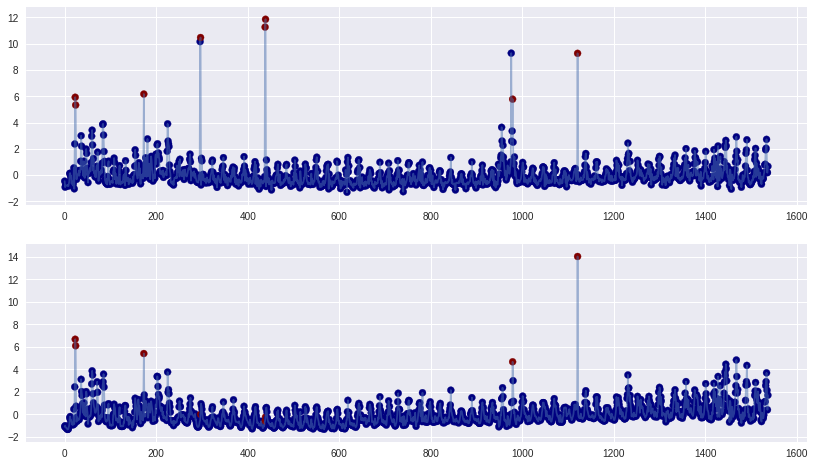

In [365]:
# LocalOutlierFactor
from sklearn.ensemble import IsolationForest

def IsolationForest_process(file_n):
    '''
    Loads a file and fits a IsolationForest class. Returns the fitted and standarized classes
    '''
    df = load_file(file_n)
    ss = StandardScaler()
    Xs = ss.fit_transform(df[['cpc','cpm']])
    isf = IsolationForest(contamination=0.005)
    isf.fit(Xs)
    
    plot_scatter_and_timeseries(Xs, -isf.predict(Xs))
    return isf, ss

isf, ss4 = IsolationForest_process(3)

<class 'sklearn.ensemble.iforest.IsolationForest'>


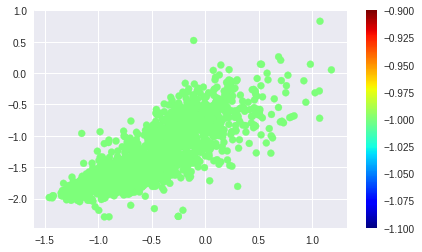

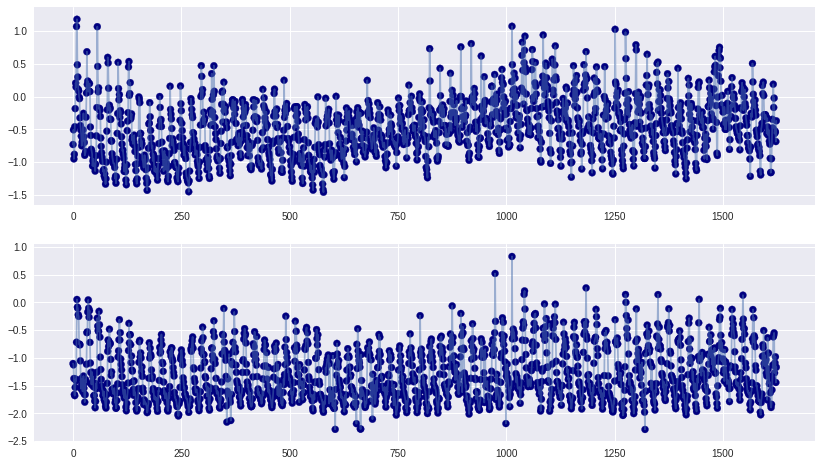

In [366]:
def w_any_process(file_n=4):
    any_process(file_n, ss=ss4, classifier=isf, invert=-1)
    
widgets.interact(w_any_process, file_n=widgets.IntSlider(
    value=4,
    min=2,
    max=4,
    step=1,
    description='File Number:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
))

## Time Series

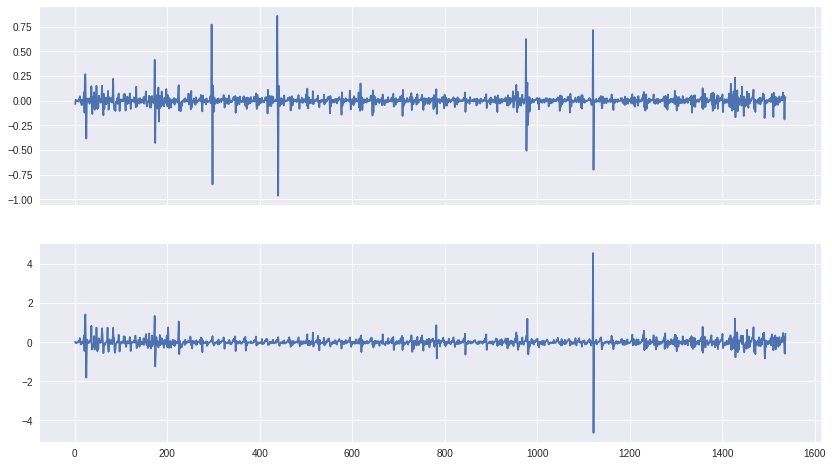

In [238]:
# Let's remove the DC value by differenciating or high passing the series
f,ax= plt.subplots(2, sharex=True, figsize=(14,8))
ax[0].plot(df['cpc'].diff())
ax[1].plot(df['cpm'].diff())

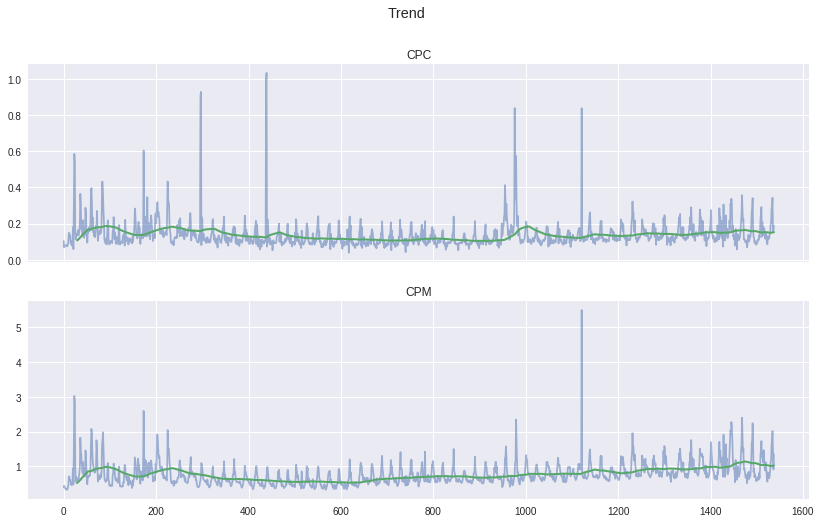

In [372]:
# Trend plot
f,ax= plt.subplots(2, sharex=True, figsize=(14,8))
ax[0].plot(df['cpc'], alpha=0.5)
ax[0].plot(df['cpc'].ewm(alpha=0.03).mean().rolling(window=30).mean(), lw=2)
ax[0].title.set_text('CPC')
ax[1].plot(df['cpm'], alpha=0.5)
ax[1].plot(df['cpm'].ewm(alpha=0.03).mean().rolling(window=30).mean(), lw=2)
ax[1].title.set_text('CPM')
plt.suptitle('Trend')

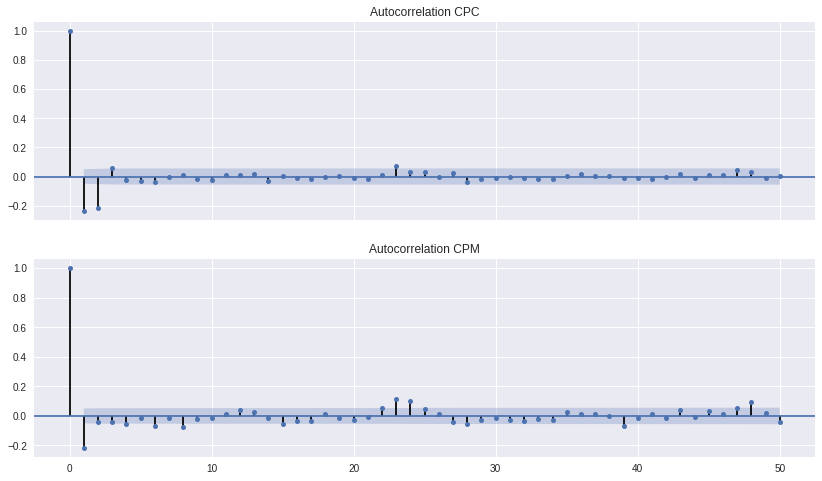

In [373]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# Let's check the autocorrelation
f,ax= plt.subplots(2, sharex=True, figsize=(14,8))
plot_acf(df['cpc'].diff()[1:].values, ax=ax[0],lags=50, title='Autocorrelation CPC')
plot_acf(df['cpm'].diff()[1:].values, ax=ax[1],lags=50, title='Autocorrelation CPM')
None

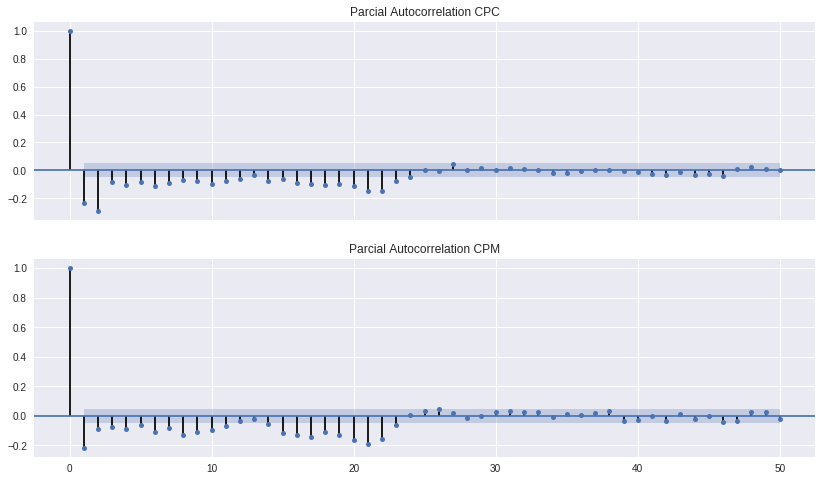

In [374]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

f,ax= plt.subplots(2, sharex=True, figsize=(14,8))
plot_pacf(df['cpc'].diff()[1:].values, ax=ax[0],lags=50, title='Parcial Autocorrelation CPC')
plot_pacf(df['cpm'].diff()[1:].values, ax=ax[1],lags=50, title='Parcial Autocorrelation CPM')
None

In [243]:
# ARIMA
from statsmodels.tsa.arima_model import ARMA
import pyflux as pf
from sklearn.metrics import r2_score

ar1 = ARMA(df['cpc'].values, (0,3,1)).fit()
print ar1.summary()

ar2 = ARMA(df['cpm'].values, (0,3,1)).fit()
print ar2.summary()

print r2_score(df['cpc'], ar1.fittedvalues)
print r2_score(df['cpm'], ar2.fittedvalues)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1538
Model:                     ARMA(0, 3)   Log Likelihood                2055.622
Method:                       css-mle   S.D. of innovations              0.064
Date:                Fri, 20 Oct 2017   AIC                          -4101.244
Time:                        13:45:03   BIC                          -4074.553
Sample:                             0   HQIC                         -4091.313
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1373      0.003     44.558      0.000       0.131       0.143
ma.L1.y        0.5317      0.026     20.610      0.000       0.481       0.582
ma.L2.y        0.2012      0.025      8.064      0.0

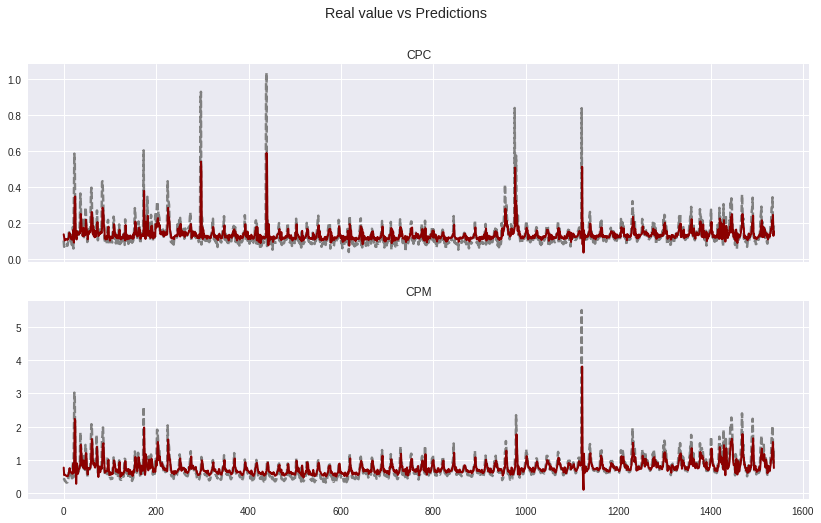

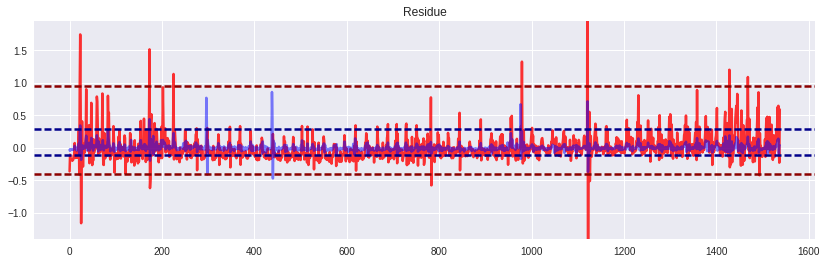

In [376]:
# First figure
fig, ax = plt.subplots(2, figsize=(14,8), sharex=True)
plt.suptitle('Real value vs Predictions')

ax[0].plot(df['cpc'], lw=2.5, color='grey', ls='dashed')
ax[0].plot(ar1.fittedvalues, lw=2, color='darkred')
ax[0].title.set_text('CPC')

ax[1].plot(df['cpm'], lw=2.5, color='grey', ls='dashed')
ax[1].plot(ar2.fittedvalues, lw=2, color='darkred')
ax[1].title.set_text('CPM')

# Second Figure - Residuals
f = plt.figure(figsize=(14,4))
plt.title('Residue')
plt.plot(ar2.resid, lw=2.5, color='red', alpha=0.8)
plt.plot(ar1.resid, lw=2.5, color='blue', alpha=0.5)

percentiles_ar1 = np.percentile(ar1.resid, [0.5, 99.5])
percentiles_ar2 = np.percentile(ar2.resid, [0.5, 99.5])

plt.axhline(y=percentiles_ar1[0], c='darkblue', linestyle='--', lw=2.5)
plt.axhline(y=percentiles_ar1[1], c='darkblue', linestyle='--', lw=2.5)

plt.axhline(y=percentiles_ar2[0], c='darkred', linestyle='--', lw=2.5)
plt.axhline(y=percentiles_ar2[1], c='darkred', linestyle='--', lw=2.5)

ax = plt.gca()
ax.set_ylim([min(percentiles_ar1[0],percentiles_ar2[0])-1,\
            max(percentiles_ar1[1],percentiles_ar2[1])+1])
None

In [377]:
def ARIMA_process(file_n, th_n_std,\
                 upper_ci_cpc, lower_ci_cpc,\
                 upper_ci_cpm, lower_ci_cpm):
    '''
    Loads a file and fits a ARMA class and plot the results, detecting anomalies greater than:
    th_n_std * std(redidue)
    '''
    
    df = load_file(file_n)
    
    ar1 = ARMA(df['cpc'].values, (0,3,1)).fit()
    ar2 = ARMA(df['cpm'].values, (0,3,1)).fit()

    print "Score ARMA CPC:", r2_score(df['cpc'], ar1.fittedvalues)
    print "Score ARMA CPM:", r2_score(df['cpm'], ar2.fittedvalues)

    ar1_res_std = ar1.resid.std()
    ar2_res_std = ar2.resid.std()
    
    detect = lambda x,y: [1 if xi < -th_n_std*y or xi > th_n_std*y else 0 \
                     for xi in x]
    
    detected1 = detect(ar1.resid, ar1_res_std)
    detected2 = detect(ar2.resid, ar2_res_std)
    detected = detected1 or detected2

    print np.mean(detected), sum(detected)
    plot_scatter_and_timeseries(df[['cpc','cpm']].values, detected)
    
def w_ARIMA(file_n=4, th_n_std=5,\
            upper_ci_cpc=99.5, lower_ci_cpc=0.5, upper_ci_cpm=99.5, lower_ci_cpm=0.5):
    ARIMA_process(file_n, th_n_std, upper_ci_cpc, lower_ci_cpc, upper_ci_cpm, lower_ci_cpm)

Score ARMA CPC: 0.00391788725586
Score ARMA CPM: 0.00217820858677
0.00486914181376 8


<function __main__.w_ARIMA>

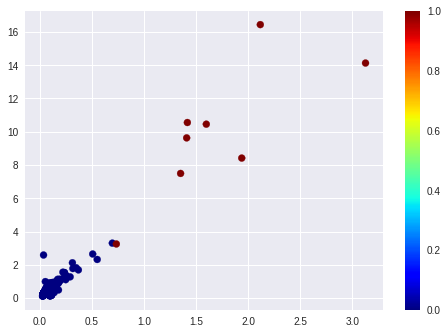

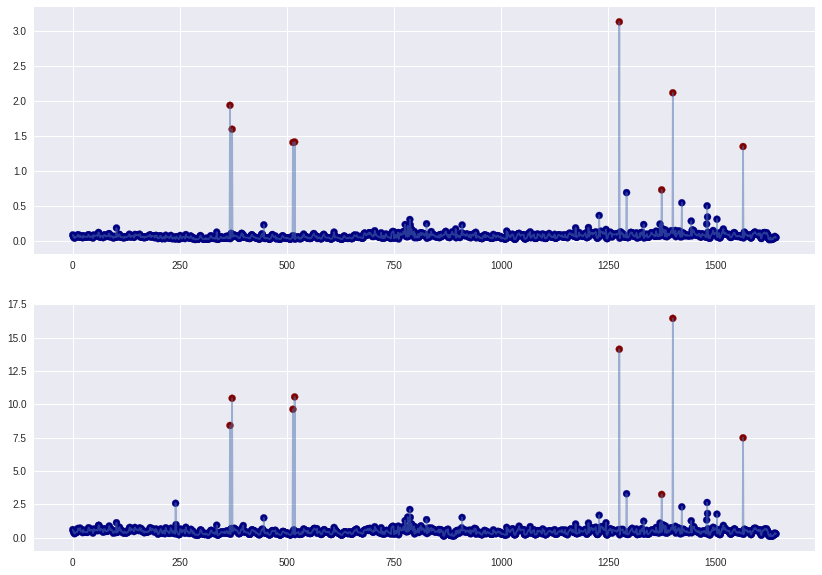

In [231]:
widgets.interact(w_ARIMA, \
    file_n=widgets.IntSlider(
        value=4,
        min=2,
        max=4,
        step=1,
        description='File Number:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'), 
    
    th_n_std = widgets.FloatText(
        value=5,
        description='Threshold:',
        disabled=False),      
    upper_ci_cpc = widgets.FloatText(
        value=99.5,
        description='Upper CI for CPC:',
        disabled=False),
    lower_ci_cpc = widgets.FloatText(
        value=0.5,
        description='Lower CI for CPC:',
        disabled=False),
    upper_ci_cpm = widgets.FloatText(
        value=99.5,
        description='Upper CI for CPM:',
        disabled=False),
    lower_ci_cpm = widgets.FloatText(
        value=0.5,
        description='Lower CI for CPM:',
        disabled=False)
    )